In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
font = {'size'   : 12}
mpl.rc('font', **font)

In [3]:
import numpy as np
import pandas as pd

In [4]:
from navec import Navec
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
#path = '/home/surov/Library/navec_news_v1_1B_250K_300d_100q.tar'
model = Navec.load(path)

In [5]:
model['карта'].shape

(300,)

In [6]:
if "машиною" in model.vocab and "машина" in model.vocab:
    print(1)

1


In [ ]:
'''from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
y''';

# Загрузка и приготовление данных

In [7]:
from sqlite3 import connect
conn = connect('new_db') # подключение к новой БД sqlite, которая будет создана после выполнения строки

cursor = conn.cursor()
with open('words-russian-nouns-morf.sql') as f:
    cursor.executescript(f.read())  # чтение обновленного .sql скрипта и выполнение с помощью курсора

data = pd.read_sql('SELECT * from nouns_morf', conn)
data

,IID,word,code,code_parent,plural,gender,wcase,soul
0,43,а-ля фуршет,4155484,0,0,муж,им,0.0
1,44,а-ля фуршета,219378,4155484,0,муж,род,0.0
2,45,а-ля фуршету,219379,4155484,0,муж,дат,0.0
3,46,а-ля фуршет,219380,4155484,0,муж,вин,0.0
4,47,а-ля фуршетом,219381,4155484,0,муж,тв,0.0
...,...,...,...,...,...,...,...,...
767689,4159363,ящурок,1511475,1511474,1,None,род,1.0
767690,4159364,ящуркам,1511476,1511474,1,None,дат,1.0
767691,4159365,ящурок,1511477,1511474,1,None,вин,1.0
767692,4159366,ящурками,1511478,1511474,1,None,тв,1.0


In [111]:
data['gender'].unique()

array(['муж', 'жен', None, 'ср', 'общ'], dtype=object)

In [10]:
# Беру из данных слова входящие в 10к самых используемых. Только именительный падеж и единственное число
topwords = pd.read_csv('10000-russian-words.txt', sep=" ", header=None)
topwords.columns = ['word']
topwords

,word
0,и
1,в
2,не
3,на
4,я
...,...
9991,нехитрый
9992,мерзавец
9993,юго
9994,дистанционный


In [12]:
codes = data[data["word"].isin(topwords["word"])]
codes = codes[(codes["code_parent"] == 0) & (codes["wcase"] == "им") & (codes["plural"] == 0)]
codes.reset_index(inplace=True)
codes

,index,IID,word,code,code_parent,plural,gender,wcase,soul
0,319,578,абзац,125731,0,0,муж,им,0.0
1,557,1033,абонент,125738,0,0,муж,им,1.0
2,631,1434,аборт,7,0,0,муж,им,0.0
3,1031,3085,абсурд,19,0,0,муж,им,0.0
4,1201,3379,авангард,25,0,0,муж,им,0.0
...,...,...,...,...,...,...,...,...,...
4463,766643,4156977,ярость,22821,0,0,жен,им,0.0
4464,767032,4157803,ясность,22833,0,0,жен,им,0.0
4465,767367,4158498,яхта,22839,0,0,жен,им,0.0
4466,767454,4158748,ячейка,22845,0,0,жен,им,0.0


In [14]:
# Таблица шести основных падежей при условии что все они присутствуют в модели word2vec
dt = pd.DataFrame(columns=["род", "пред", "вин", "им", "дат", "твор"], dtype=str)

kl = []
for i in range(len(codes)):
    di = data[(data["code_parent"] == codes.iloc[i]["code"]) & (data["plural"] == 0)]
    if len(di) == 5:
        ime = codes.iloc[i]["word"]
        rod = di[di["wcase"] == "род"].iloc[0]["word"]
        pre = di[di["wcase"] == "пр"].iloc[0]["word"]
        vin = di[di["wcase"] == "вин"].iloc[0]["word"]
        dat = di[di["wcase"] == "дат"].iloc[0]["word"]
        tvo = di[di["wcase"] == "тв"].iloc[0]["word"]
        
        lis= [rod, pre, vin, ime, dat, tvo]
        
        k = 0
        for j in range(6):
            if lis[j] not in model.vocab: k += 1
        kl.append(k)
        if k == 0: dt.loc[i] = lis

dt.reset_index(inplace=True, drop=True)
print('Число слов без какого-либо падежа', np.array(kl).sum(), 'из', len(dt)+np.array(kl).sum())
dt

Число слов без какого-либо падежа 268 из 3159


,род,пред,вин,им,дат,твор
0,абзаца,абзаце,абзац,абзац,абзацу,абзацем
1,аборта,аборте,аборт,аборт,аборту,абортом
2,абсурда,абсурде,абсурд,абсурд,абсурду,абсурдом
3,авангарда,авангарде,авангард,авангард,авангарду,авангардом
4,аварии,аварии,аварию,авария,аварии,аварией
...,...,...,...,...,...,...
2886,японца,японце,японца,японец,японцу,японцем
2887,яркости,яркости,яркость,яркость,яркости,яркостью
2888,ярости,ярости,ярость,ярость,ярости,яростью
2889,ясности,ясности,ясность,ясность,ясности,ясностью


In [15]:
#dt.to_csv('data_6x2891.csv')

# Совпадение классов

In [15]:
# Число уникальных слов в строках
dtu = dt.nunique(axis=1)

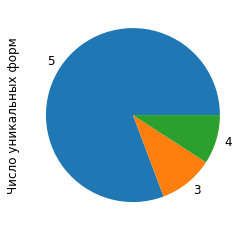

In [16]:
dtu.value_counts().plot(kind='pie',label='Число уникальных форм');

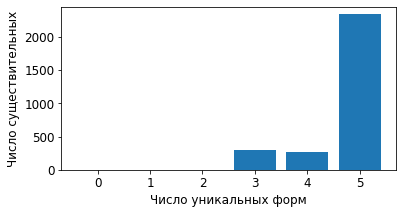

In [17]:
fig,ax = plt.subplots(1,1,figsize=(6,3))
ax.hist(dtu, bins=6, range=[0,6], align='left', rwidth=0.8);
ax.set_xlabel('Число уникальных форм')
ax.set_ylabel('Число существительных');

In [18]:
# Основное совпадение форм между винительным и именительным падежами
dt[dt['вин'] != dt['им']]

,род,пред,вин,им,дат,твор
4,аварии,аварии,аварию,авария,аварии,аварией
6,авиации,авиации,авиацию,авиация,авиации,авиацией
7,австралии,австралии,австралию,австралия,австралии,австралией
10,автоматизации,автоматизации,автоматизацию,автоматизация,автоматизации,автоматизацией
12,автономии,автономии,автономию,автономия,автономии,автономией
...,...,...,...,...,...,...
2864,эпидемии,эпидемии,эпидемию,эпидемия,эпидемии,эпидемией
2877,юриста,юристе,юриста,юрист,юристу,юристом
2878,юстиции,юстиции,юстицию,юстиция,юстиции,юстицией
2883,яка,яке,яка,як,яку,яком


In [66]:
(2891-679)/2891

0.7651331719128329

## <font color='red'>Вывод</font>
Подавляющая часть существительных имеет по 5 различных форм. В основном (у 77% слов) совпадают именительный и винительный падежи.

# Корреляция признаков

In [19]:
# Признаками являются 300 измерений word2vec. Получаем явные значения для всех 2891*6 слов
dtf = dt.to_numpy().flatten()
dt_vec = np.array([model[v] for v in dtf])
dt_vec.shape

(17346, 300)

In [20]:
# Корреляция Пирсона
cormat = np.corrcoef(dt_vec, rowvar=False)
cormat.shape

(300, 300)

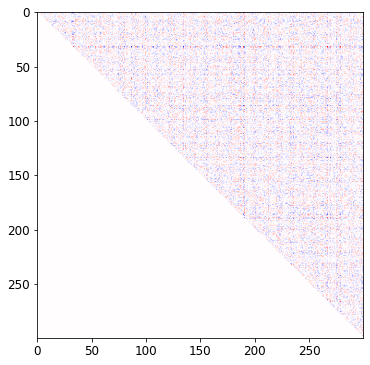

In [21]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(np.triu(cormat, k=1)[0:300,0:300], cmap="seismic", vmin=-1, vmax=1);

In [22]:
np.triu(cormat, k=1).max()

0.43823135382832173

## <font color='red'>Вывод</font>
Вопиющих корреляций не наблюдется. Похоже что об этом позаботились создатели модели

# Приготовление данных 2

In [118]:
# Таблица шести основных падежей при условии что все они присутствуют в модели word2vec
dt = pd.DataFrame(columns=["R", "P", "V", "I", "D", "T", "pol", "dush"], dtype=str)

kl = []
for i in range(len(codes)):
    di = data[(data["code_parent"] == codes.iloc[i]["code"]) & (data["plural"] == 0)]
    if len(di) == 5:
        ime = codes.iloc[i]["word"]
        rod = di[di["wcase"] == "род"].iloc[0]["word"]
        pre = di[di["wcase"] == "пр"].iloc[0]["word"]
        vin = di[di["wcase"] == "вин"].iloc[0]["word"]
        dat = di[di["wcase"] == "дат"].iloc[0]["word"]
        tvo = di[di["wcase"] == "тв"].iloc[0]["word"]
        
        if codes.iloc[i]["gender"] == 'муж': pol = 'М'
        elif codes.iloc[i]["gender"] == 'жен': pol = 'Ж'
        else: pol = codes.iloc[i]["gender"]
        odu  = codes.iloc[i]["soul"]
        
        lis= [rod, pre, vin, ime, dat, tvo, pol, odu]
        
        k = 0
        for j in range(6):
            if lis[j] not in model.vocab: k += 1
        kl.append(k)
        if k == 0: dt.loc[i] = lis

dt.reset_index(inplace=True, drop=True)
print('Число слов без какого-либо падежа:', np.array(kl).sum())
dt

Число слов без какого-либо падежа 268


,R,P,V,I,D,T,pol,dush
0,абзаца,абзаце,абзац,абзац,абзацу,абзацем,М,0.0
1,аборта,аборте,аборт,аборт,аборту,абортом,М,0.0
2,абсурда,абсурде,абсурд,абсурд,абсурду,абсурдом,М,0.0
3,авангарда,авангарде,авангард,авангард,авангарду,авангардом,М,0.0
4,аварии,аварии,аварию,авария,аварии,аварией,Ж,0.0
...,...,...,...,...,...,...,...,...
2886,японца,японце,японца,японец,японцу,японцем,М,1.0
2887,яркости,яркости,яркость,яркость,яркости,яркостью,Ж,0.0
2888,ярости,ярости,ярость,ярость,ярости,яростью,Ж,0.0
2889,ясности,ясности,ясность,ясность,ясности,ясностью,Ж,0.0


In [122]:
dt.to_csv('data_8x2891.csv')

In [88]:
N = len(dt)
N

2891

In [119]:
df = pd.DataFrame(columns=['word', 'pad'])
for i in range(N):
    for p in ["R", "P", "V", "I", "D", "T"]:
        df = df.append({'word': dt.iloc[i][p], 'pad': p}, ignore_index=True)

In [120]:
df

,word,pad
0,абзаца,R
1,абзаце,P
2,абзац,V
3,абзац,I
4,абзацу,D
...,...,...
17341,ящике,P
17342,ящик,V
17343,ящик,I
17344,ящику,D


In [121]:
df.to_csv('data_1x17346.csv')